In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import kernel_approximation
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
rcParams['figure.figsize'] = 15, 5
print("hamza")

hamza


In [2]:
data = pd.read_csv('No-show-Issue-Comma-300k.csv')
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


In [3]:
print("Data size:", len(data))

Data size: 300000


In [4]:
for column in list(data.columns):
    print("{0:25} {1}".format(column, data[column].nunique()))

Age                       109
Gender                    2
AppointmentRegistration   295425
ApointmentData            534
DayOfTheWeek              7
Status                    2
Diabetes                  2
Alcoolism                 2
HiperTension              2
Handcap                   5
Smokes                    2
Scholarship               2
Tuberculosis              2
Sms_Reminder              3
AwaitingTime              213


In [5]:
def features_plots(discrete_vars):
    plt.figure(figsize=(15, 24.5))
    for i, cv in enumerate(['Age', 'AwaitingTime']):
        plt.subplot(7, 2, i+1)
        plt.hist(data[cv], bins=len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')
    
    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+3)
        data[dv].value_counts().plot(kind='bar', title=dv)
        plt.ylabel('Frequency')

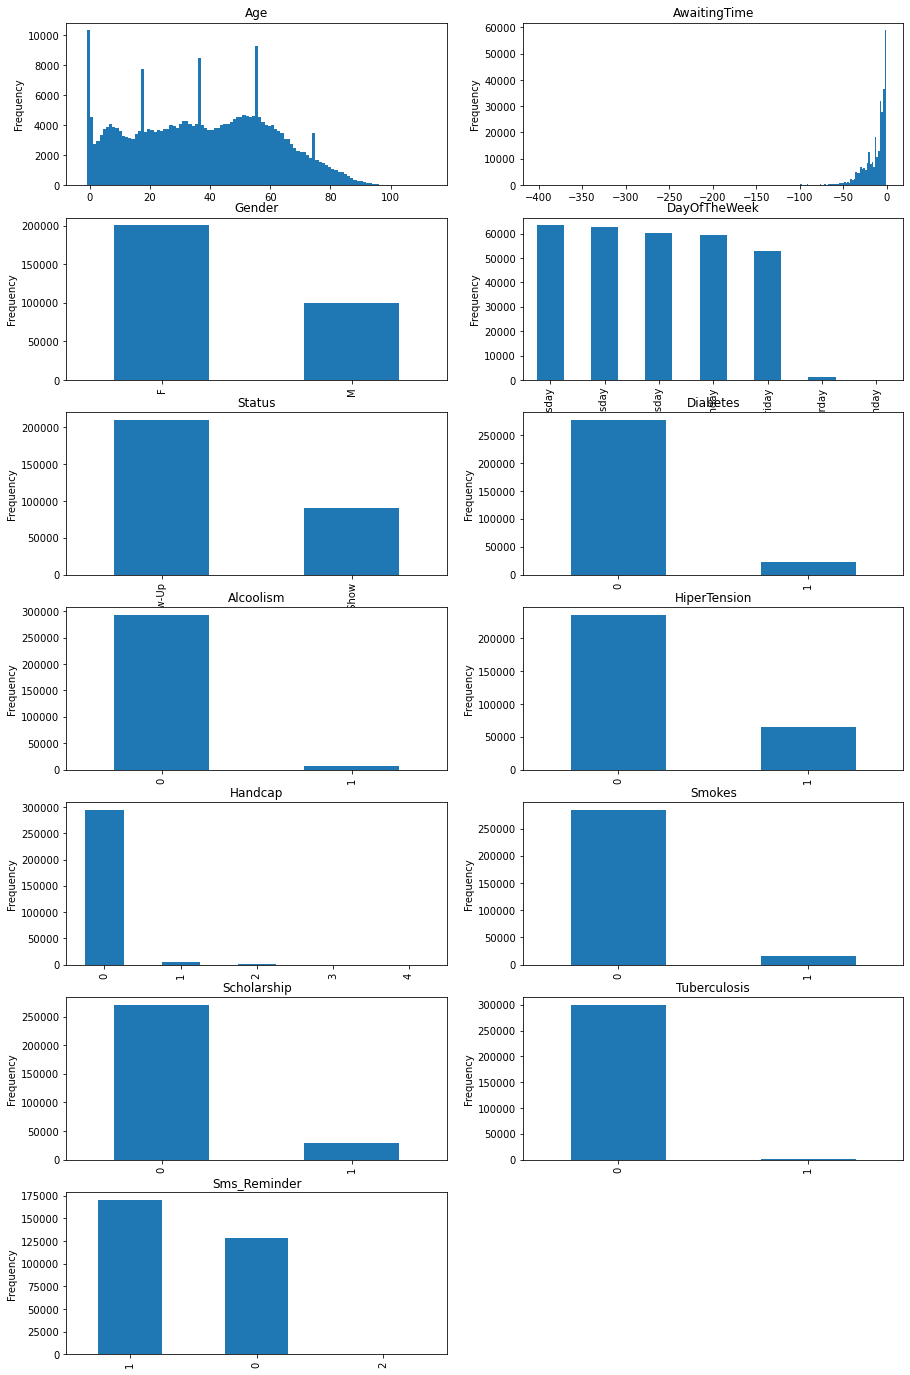

In [6]:
discrete_vars=['Gender', 'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism',
               'HiperTension', 'Handcap', 'Smokes','Scholarship', 
               'Tuberculosis', 'Sms_Reminder']
features_plots(discrete_vars)

In [7]:
data[data['Age'] < 0].value_counts().sum()
data = data[data['Age'] >=0]

In [8]:
del data['Handcap']
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,1,-6


In [9]:
data['AwaitingTime'] = data['AwaitingTime'].apply(lambda x: abs(x))

In [10]:
dow_mapping = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2,
              'Thursday' : 3, 'Friday' : 4, 'Saturday' : 5, 'Sunday' : 6}
data['DayOfTheWeek'] = data['DayOfTheWeek'].map(dow_mapping)
print(data['DayOfTheWeek'])


0         2
1         2
2         1
3         3
4         1
         ..
299995    2
299996    1
299997    4
299998    3
299999    2
Name: DayOfTheWeek, Length: 299994, dtype: int64


In [11]:
for field in ['Gender', 'Status']:
    data[field] = pd.Categorical(data[field]).codes

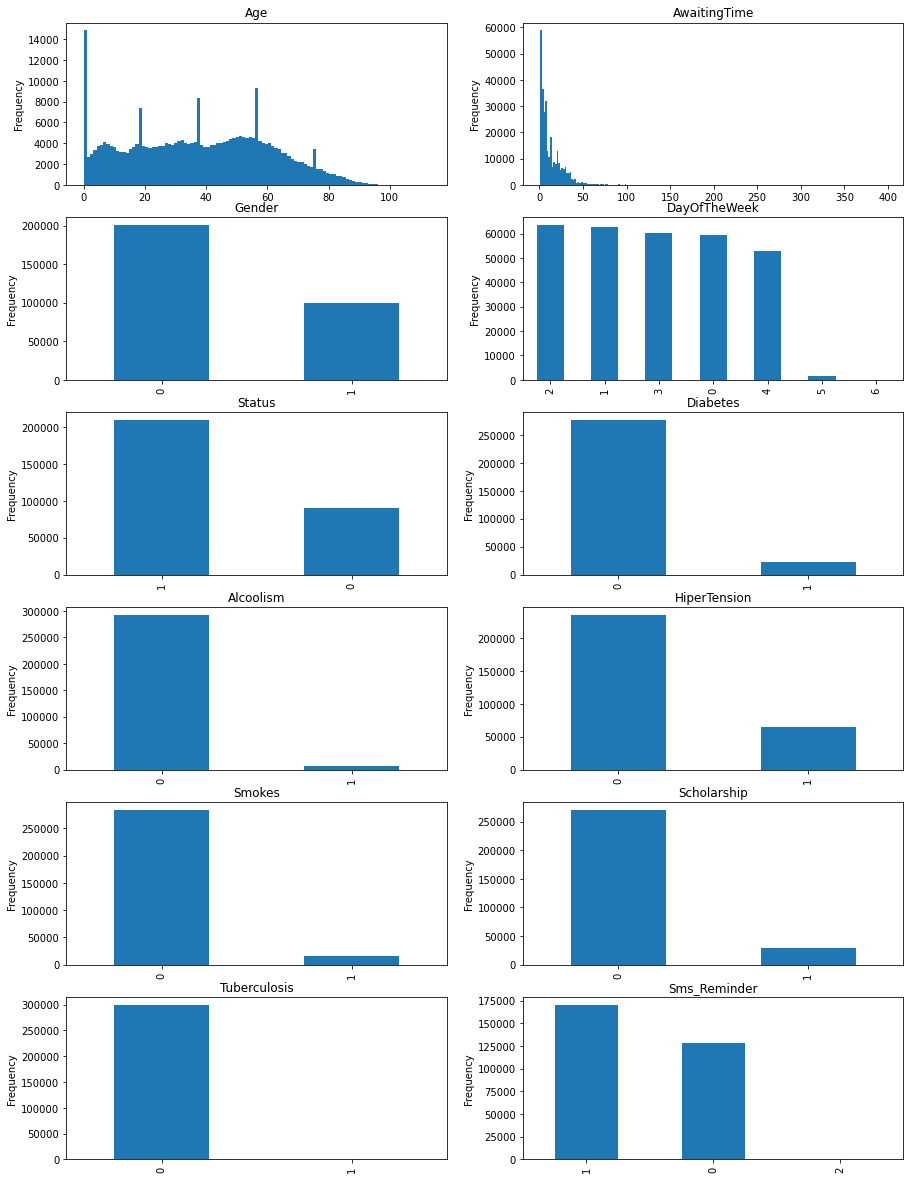

In [12]:
discrete_vars=['Gender', 'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoolism',
               'HiperTension', 'Smokes','Scholarship', 
               'Tuberculosis', 'Sms_Reminder']
features_plots(discrete_vars)

(0.0, 120.0)

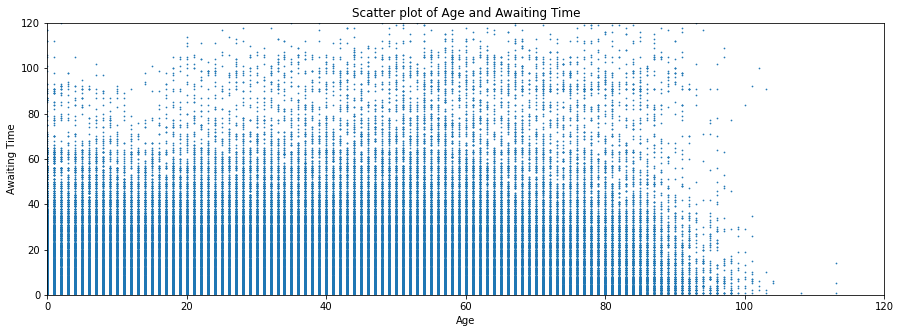

In [13]:
plt.scatter(data['Age'], data['AwaitingTime'], s=0.5)
plt.title('Scatter plot of Age and Awaiting Time')
plt.xlabel('Age')
plt.ylabel('Awaiting Time')
plt.xlim(0, 120)
plt.ylim(0, 120)

In [14]:
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data[['Age', 'AwaitingTime']].corr(method='pearson')
print(correlations)

                Age  AwaitingTime
Age           1.000        -0.004
AwaitingTime -0.004         1.000


Text(0, 0.5, 'Frequency')

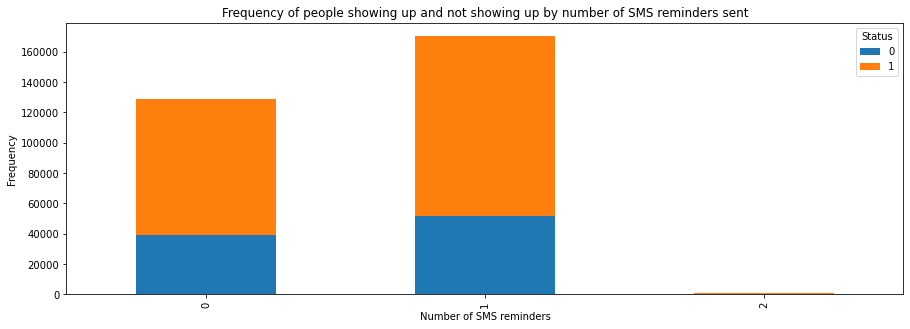

In [15]:
data_dow_status = data.groupby(['Sms_Reminder', 'Status'])['Sms_Reminder'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by number of SMS reminders sent')
plt.xlabel('Number of SMS reminders')
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

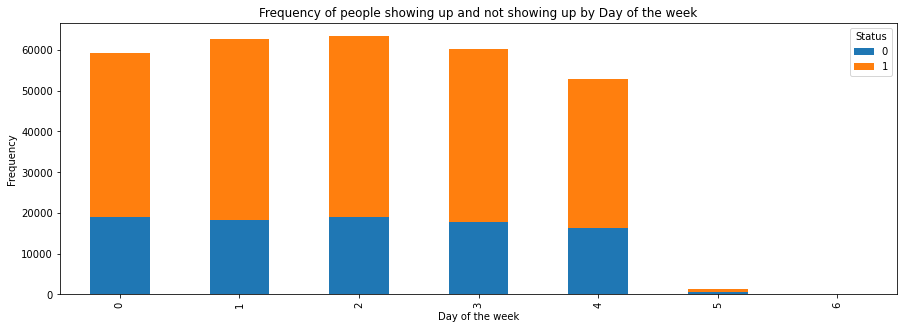

In [16]:
data_dow_status = data.groupby(['DayOfTheWeek', 'Status'])['DayOfTheWeek'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Frequency')

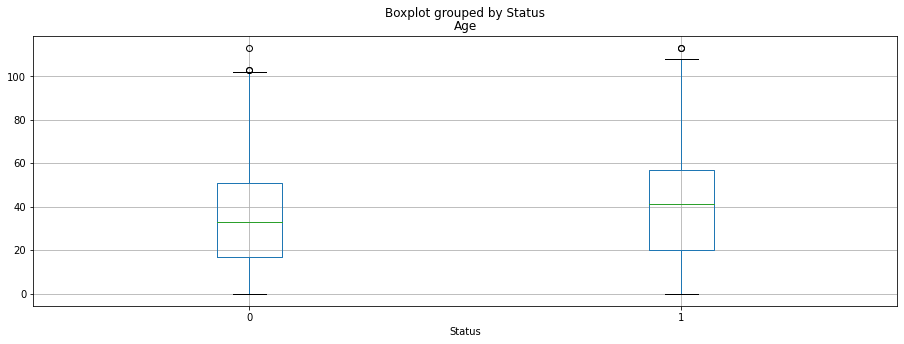

In [17]:
data.boxplot(column=['Age'], return_type='axes', by='Status')
plt.show()

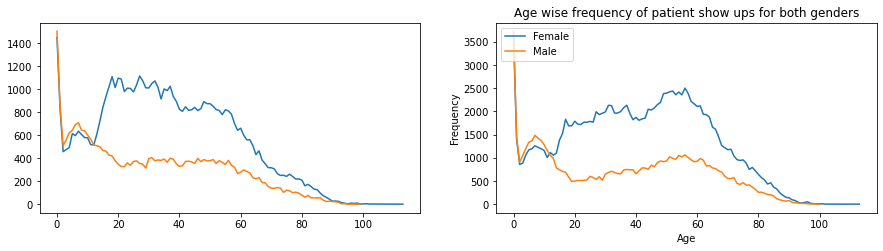

In [18]:
plt.figure(figsize=(15, 3.5))
for i, status in enumerate(['no show ups', 'show ups']):
    data_show = data[data['Status']==i]
    plt.subplot(1, 2, i+1)
    
    for gender in [0, 1]:
        data_gender = data_show[data_show['Gender']==gender]
        freq_age = data_gender['Age'].value_counts().sort_index()
        freq_age.plot()
    
plt.title('Age wise frequency of patient %s for both genders'%status)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Female', 'Male'], loc='upper left')


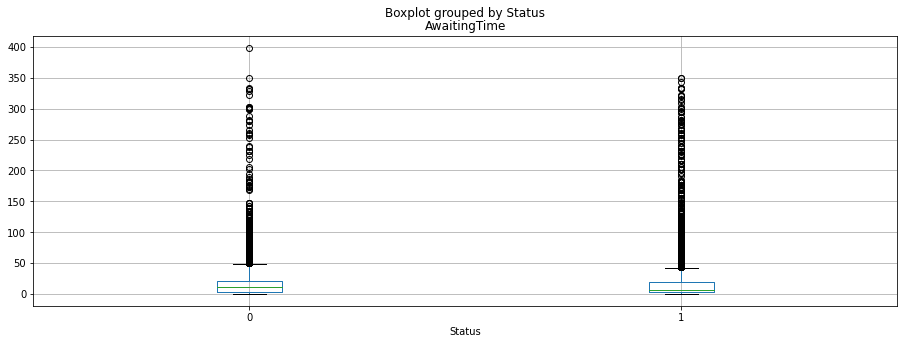

In [19]:
data.boxplot(column=['AwaitingTime'], return_type='axes', by='Status')
plt.show()

In [20]:
for col in ['AppointmentRegistration', 'ApointmentData']:
    for index, component in enumerate(['year', 'month', 'day']):
        data['%s_%s'%(col, component)] = data[col].apply(lambda x:int(x.split('T')[0].split('-')[index]))

In [21]:
for index, component in enumerate(['hour', 'min', 'sec']):
    data['%s_%s'%('AppointmentRegistration', component)] = data['AppointmentRegistration'].apply(lambda x: int(x.split('T')[1][:-1].split(':')[index]))

In [22]:
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,...,AwaitingTime,AppointmentRegistration_year,AppointmentRegistration_month,AppointmentRegistration_day,ApointmentData_year,ApointmentData_month,ApointmentData_day,AppointmentRegistration_hour,AppointmentRegistration_min,AppointmentRegistration_sec
0,19,1,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,2,1,0,0,0,0,...,29,2014,12,16,2015,1,14,14,46,25
1,24,0,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,2,1,0,0,0,0,...,1,2015,8,18,2015,8,19,7,1,26
2,4,0,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,1,1,0,0,0,0,...,1,2014,2,17,2014,2,18,12,53,46
3,5,1,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,3,1,0,0,0,0,...,15,2014,7,23,2014,8,7,17,2,11
4,38,1,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,1,1,0,0,0,0,...,6,2015,10,21,2015,10,27,15,20,9


In [23]:
def model_performance(model_name, X_train, y_train, y_test, Y_pred):
    print('Model name: %s'%model_name)
    print('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_test, Y_pred))
    print('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(y_test, Y_pred))
    print('Train accuracy: %f'%clf.score(X_train, y_train))
    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    print( 'Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [24]:
features_of_choice = [u'Age', u'Gender', 'DayOfTheWeek', 'Diabetes','Alcoolism', 'HiperTension',
                      'Smokes', 'Scholarship', 'Tuberculosis','Sms_Reminder',
                      'AwaitingTime', 'AppointmentRegistration_year','AppointmentRegistration_month',
                      'AppointmentRegistration_day', 'ApointmentData_year', 'ApointmentData_month','ApointmentData_day', 'AppointmentRegistration_hour', 'AppointmentRegistration_min',
                      'AppointmentRegistration_sec']
x = np.array(data[features_of_choice])
y = np.array(data['Status'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=1)

In [25]:
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier()

Model name: Decision tree classifier
Test accuracy (Accuracy Score): 0.588862
Test accuracy (ROC AUC Score): 0.523159
Train accuracy: 0.999952
Area Under the Precision-Recall Curve: 0.112421


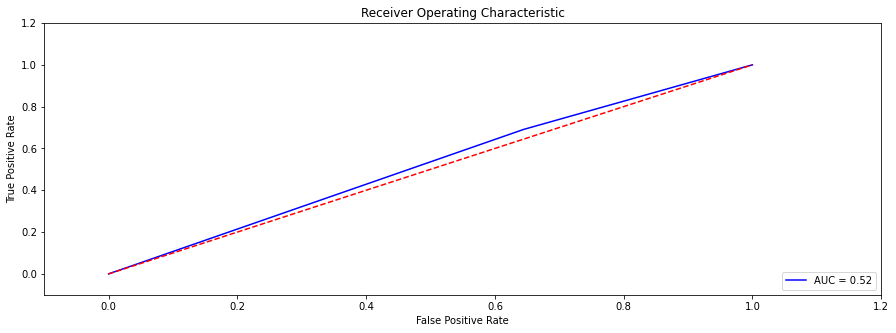

In [26]:
y_pred = clf.predict(x_test)
model_performance('Decision tree classifier', x_train, y_train, y_test,y_pred)

In [27]:
rbf_feature = kernel_approximation.RBFSampler(gamma=1, random_state=1)
X_train = rbf_feature.fit_transform(x_train)
clf = SGDClassifier()
clf.fit(X_train, y_train)

SGDClassifier()

Model name: Kernel approximation
Test accuracy (Accuracy Score): 0.695619
Test accuracy (ROC AUC Score): 0.500000
Train accuracy: 0.698398
Area Under the Precision-Recall Curve: 0.152191


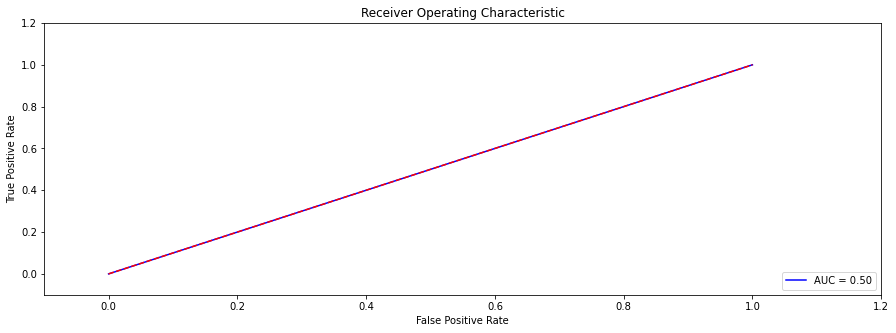

In [28]:
X_test = rbf_feature.fit_transform(x_test)
Y_pred = clf.predict(X_test)
model_performance('Kernel approximation', X_train, y_train, y_test, Y_pred)

In [29]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

RandomForestClassifier()

In [30]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_split=1e-07, min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,n_estimators=10,
                       n_jobs=1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(min_impurity_split=1e-07, n_estimators=10, n_jobs=1)

Model name: Random Forest
Test accuracy (Accuracy Score): 0.693252
Test accuracy (ROC AUC Score): 0.524425
Train accuracy: 0.999952
Area Under the Precision-Recall Curve: 0.150981


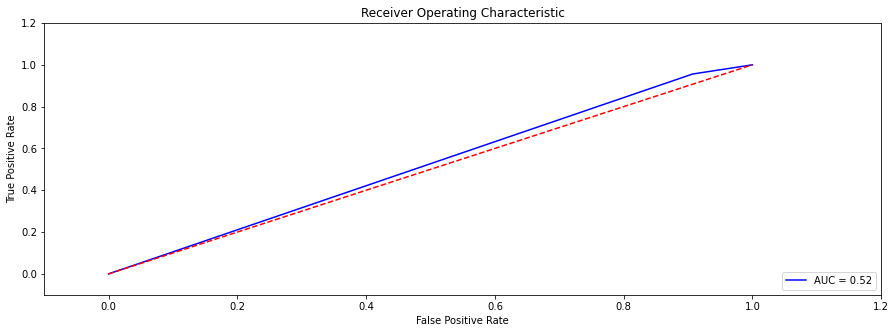

In [31]:
y_pred = clf.predict(x_test)
model_performance('Random Forest', x_train, y_train, y_test, y_pred)

In [32]:
clf = GradientBoostingClassifier(random_state=10, learning_rate=0.1,n_estimators=200, max_depth=5, max_features=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

Model name: Gradient Boosting
Test accuracy (Accuracy Score): 0.700563
Test accuracy (ROC AUC Score): 0.515657
Train accuracy: 0.707488
Area Under the Precision-Recall Curve: 0.153793


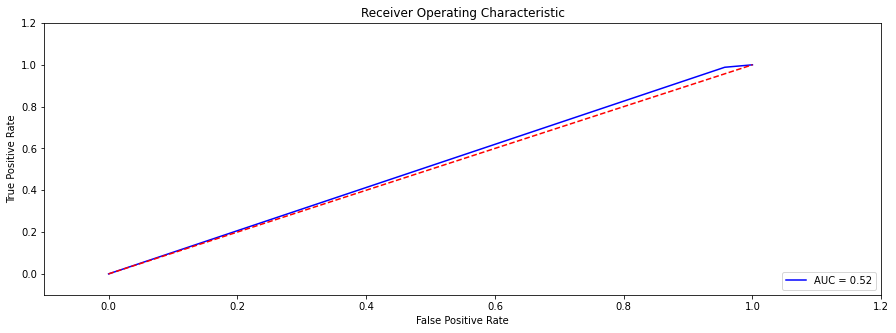

In [35]:
model_performance('Gradient Boosting', x_train, y_train, y_test, y_pred)


In [36]:
for feature, score in zip(features_of_choice, list(clf.feature_importances_)):
    print('%s\t%f'%(feature, score))

Age	0.285888
Gender	0.006376
DayOfTheWeek	0.044161
Diabetes	0.003007
Alcoolism	0.014232
HiperTension	0.006872
Smokes	0.018557
Scholarship	0.013967
Tuberculosis	0.001170
Sms_Reminder	0.042786
AwaitingTime	0.197892
AppointmentRegistration_year	0.018191
AppointmentRegistration_month	0.027772
AppointmentRegistration_day	0.034201
ApointmentData_year	0.021829
ApointmentData_month	0.050525
ApointmentData_day	0.076830
AppointmentRegistration_hour	0.059602
AppointmentRegistration_min	0.040108
AppointmentRegistration_sec	0.036033
